In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import phate # For PHATE dimensionality reduction
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import ttest_ind # For t-test as an alternative DGE method
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from statsmodels.stats.multitest import multipletests # For multiple hypothesis correction
import gseapy as gp # For Gene Set Enrichment Analysis
import warnings

In [2]:
# Suppress warnings for cleaner output, but be mindful in a production setting
warnings.filterwarnings('ignore')

# --- 0. Configuration and File Paths ---
GENE_EXPRESSION_FILE = 'provided_data/CRC_atlas_gene_expression_data.csv'
CLINICAL_DATA_FILE = 'provided_data/CRC_atlas_clinical_data.csv'

# Define the column name in your clinical data that represents the sample type
SAMPLE_TYPE_COL = 'Sample type'
# Define the values for healthy and primary cancer in your sample_type column
HEALTHY_SAMPLE_TYPE = 'Healthy sample'
CANCER_SAMPLE_TYPE = 'Primary cancer'
# Define the column name in your clinical data that represents the biopsy site
BIOPSY_SITE_COL = 'Biopsy site'


In [3]:
# --- 1. Data Loading ---
print("--- 1. Data Loading ---")
try:
    # Load gene expression data
    # Assuming the first column is gene IDs and subsequent columns are samples.
    # We will transpose later if samples are not already rows.
    gene_expression_df = pd.read_csv(GENE_EXPRESSION_FILE, index_col=0)

    # Load clinical metadata
    # Assuming the first column is sample IDs and subsequent columns are clinical features.
    clinical_df = pd.read_csv(CLINICAL_DATA_FILE, index_col=0) # Assuming sample IDs are in the first column

    print("Data loading successful.")
    print(f"Initial Gene Expression Data Shape: {gene_expression_df.shape}")
    print(f"Initial Clinical Data Shape: {clinical_df.shape}")

    # Ensure gene expression data has samples as rows and genes as columns for most analyses
    # Check if the number of rows is much larger than columns (implies genes are rows)
    if gene_expression_df.shape[0] > gene_expression_df.shape[1]:
        print("Transposing gene expression data: genes as rows -> samples as rows.")
        gene_expression_df = gene_expression_df.T
    
    # Ensure clinical data index matches gene expression data index (sample IDs)
    # This is crucial for merging and aligning data.
    common_samples = gene_expression_df.index.intersection(clinical_df.index)
    if len(common_samples) == 0:
        raise ValueError("No common sample IDs found between gene expression and clinical data. "
                         "Please check your file formats and index columns.")

    gene_expression_df = gene_expression_df.loc[common_samples]
    clinical_df = clinical_df.loc[common_samples]

    print(f"\nAligned Gene Expression Data Shape: {gene_expression_df.shape} (Samples x Genes)")
    print(f"Aligned Clinical Data Shape: {clinical_df.shape} (Samples x Features)")

except FileNotFoundError as e:
    print(f"Error: One of the data files was not found. Please check the paths: {e}")
    print("Ensure 'GENE_EXPRESSION_FILE' and 'CLINICAL_DATA_FILE' are correctly set.")
    exit() # Exit if files are not found
except Exception as e:
    print(f"An unexpected error occurred during data loading or alignment: {e}")
    exit() # Exit for other critical loading errors


--- 1. Data Loading ---
Data loading successful.
Initial Gene Expression Data Shape: (22723, 2770)
Initial Clinical Data Shape: (2770, 34)
Transposing gene expression data: genes as rows -> samples as rows.

Aligned Gene Expression Data Shape: (2770, 22723) (Samples x Genes)
Aligned Clinical Data Shape: (2770, 34) (Samples x Features)


In [4]:
# --- 2. Initial Data Inspection and Quality Check ---
print("\n--- 2. Initial Data Inspection and Quality Check ---")

# Add the sample IDs (row names) as a new column for easier access and merging later.
clinical_df['Sample_ID'] = clinical_df.index
print("Added 'Sample_ID' column to clinical data from row names.")

print("\n--- Gene Expression Data (Head) ---")
print(gene_expression_df.head())
print("\n--- Clinical Data (Head) ---")
print(clinical_df.head())

print(f"\nGene Expression Data Dimensions: {gene_expression_df.shape}")
print(f"Clinical Data Dimensions: {clinical_df.shape}")

print("\n--- Gene Expression Data Info ---")
gene_expression_df.info()
print("\n--- Clinical Data Info ---")
clinical_df.info()

print("\n--- Gene Expression Data Descriptive Statistics ---")
print(gene_expression_df.describe().T.head()) # Show head for brevity due to many genes
print("\n--- Clinical Data Descriptive Statistics (Numerical) ---")
print(clinical_df.describe(include=np.number).T)
print("\n--- Clinical Data Descriptive Statistics (Categorical) ---")
print(clinical_df.describe(include='object').T)

print("\n--- Clinical Data Unique Values Count ---")
print(clinical_df.nunique())


--- 2. Initial Data Inspection and Quality Check ---
Added 'Sample_ID' column to clinical data from row names.

--- Gene Expression Data (Head) ---
            A1BG  A1BG-AS1   A1CF     A2M  A2M-AS1  A2ML1  A2MP1  A3GALT2  \
GSM1133352   1.0       1.0   73.0   116.0      3.0    2.0    0.0      0.0   
GSM1133353   7.0       3.0    2.0   261.0      3.0    1.0    0.0      0.0   
GSM1133355   1.0       0.0    6.0    12.0      1.0    0.0    0.0      0.0   
GSM2042099   9.0      17.0  272.0  1229.0     41.0    2.0    0.0      0.0   
GSM2042100  46.0      44.0  241.0  6595.0    192.0    6.0    3.0      0.0   

            A4GALT  A4GNT  ...  ZWILCH  ZWINT   ZXDA   ZXDB   ZXDC  ZYG11A  \
GSM1133352     3.0    0.0  ...    13.0   13.0    7.0   14.0   46.0     1.0   
GSM1133353     8.0    3.0  ...     4.0    2.0   11.0   18.0   49.0     5.0   
GSM1133355     0.0    0.0  ...     0.0    2.0    2.0    3.0    8.0     0.0   
GSM2042099    98.0    0.0  ...   212.0  403.0  140.0  328.0  641.0     0.0  

In [5]:
# --- 3. Data Cleaning: Handling Missing Values and Duplicates ---
print("\n--- 3. Data Cleaning ---")

# First, remove any rows (samples) or columns (genes) that are entirely missing.
# This prevents dataframes from having empty dimensions.
initial_rows = gene_expression_df.shape[0]
initial_cols = gene_expression_df.shape[1]

# Remove rows (samples) with all missing values
gene_expression_df.dropna(axis=0, how='all', inplace=True)
if gene_expression_df.shape[0] < initial_rows:
    print(f"Removed {initial_rows - gene_expression_df.shape[0]} samples (rows) with all missing values.")

# Remove columns (genes) with all missing values
gene_expression_df.dropna(axis=1, how='all', inplace=True)
if gene_expression_df.shape[1] < initial_cols:
    print(f"Removed {initial_cols - gene_expression_df.shape[1]} genes (columns) with all missing values.")
    
# Check for missing values in gene expression data
missing_genes_expr = gene_expression_df.isnull().sum()
missing_genes_expr = missing_genes_expr[missing_genes_expr > 0]
if not missing_genes_expr.empty:
    print("\nMissing values found in Gene Expression Data (top 10):")
    print(missing_genes_expr.sort_values(ascending=False).head(10))
    # Strategy: Fill remaining missing values with 0.
    print("\nFilling remaining missing values in gene expression data with 0.")
    gene_expression_df.fillna(0, inplace=True)
else:
    print("\nNo missing values found in Gene Expression Data.")

# Check for missing values in clinical data
missing_clinical = clinical_df.isnull().sum()
missing_clinical = missing_clinical[missing_clinical > 0]
if not missing_clinical.empty:
    print("\nMissing values found in Clinical Data:")
    print(missing_clinical.sort_values(ascending=False))
    # For clinical data, we will report the missing values but not automatically impute them
    # as the strategy can be highly dependent on the variable.
    # Example: clinical_df['age'].fillna(clinical_df['age'].mean(), inplace=True)
else:
    print("\nNo missing values found in Clinical Data.")

# Check for duplicate rows in gene expression data only
duplicates_expr = gene_expression_df.duplicated().sum()
if duplicates_expr > 0:
    print(f"\nNumber of duplicate rows in Gene Expression Data: {duplicates_expr}")
    gene_expression_df.drop_duplicates(inplace=True)
    print("Duplicate rows in gene expression data removed.")
else:
    print("\nNo duplicate rows found in Gene Expression Data.")

# Re-align dataframes after cleaning
common_samples_cleaned = gene_expression_df.index.intersection(clinical_df.index)
gene_expression_df = gene_expression_df.loc[common_samples_cleaned]
clinical_df = clinical_df.loc[common_samples_cleaned]
print(f"\nData shapes after cleaning and re-alignment: {gene_expression_df.shape} (Expression), {clinical_df.shape} (Clinical)")

# Validate required clinical columns exist
if SAMPLE_TYPE_COL not in clinical_df.columns:
    raise ValueError(f"Required column '{SAMPLE_TYPE_COL}' not found in clinical data. Please check your clinical_csv file.")
if BIOPSY_SITE_COL not in clinical_df.columns:
    print(f"Warning: Column '{BIOPSY_SITE_COL}' not found in clinical data. Some visualizations may be skipped.")

# Filter out samples that are not 'healthy' or 'primary cancer' if other sample types exist
initial_sample_count = clinical_df.shape[0]
clinical_df = clinical_df[clinical_df[SAMPLE_TYPE_COL].isin([HEALTHY_SAMPLE_TYPE, CANCER_SAMPLE_TYPE])]
gene_expression_df = gene_expression_df.loc[clinical_df.index]
if clinical_df.shape[0] < initial_sample_count:
    print(f"Filtered out {initial_sample_count - clinical_df.shape[0]} samples not classified as '{HEALTHY_SAMPLE_TYPE}' or '{CANCER_SAMPLE_TYPE}'.")
print(f"Final sample types distribution:\n{clinical_df[SAMPLE_TYPE_COL].value_counts()}")


--- 3. Data Cleaning ---

No missing values found in Gene Expression Data.

Missing values found in Clinical Data:
HER2 mutation           2770
Grade                   2691
PFS time                2685
PFS status              2540
Molecular type          2534
Line of treatment       2429
TP53 mutation           2255
TMB group               2255
EGFR mutated            2255
TMB                     2247
KRAS mutation           2245
CMS                     2189
Therapy response        2177
BRAF mutation           2151
OS time                 2140
Cancer type             2139
OS status               2139
MSI status              1985
Stage                   1935
Therapy type            1809
Biopsy subsite          1474
Biopsy timepoint        1345
Age category            1328
Prior treatment         1222
Distal vs proximal      1108
Gender                  1037
Age                      994
Primary site             804
Histological type        804
Histological subtype     804
Tumor type    

In [6]:
# --- 4. Preprocessing for Dimensionality Reduction (Scaling) ---
print("\n--- 4. Preprocessing for Dimensionality Reduction (Scaling) ---")

# Standardize the gene expression data (Z-score scaling)
# This is important for PCA, UMAP, and PHATE to ensure all genes contribute equally.
scaler = StandardScaler()
scaled_expression_data = scaler.fit_transform(gene_expression_df)
scaled_expression_df = pd.DataFrame(scaled_expression_data,
                                    index=gene_expression_df.index,
                                    columns=gene_expression_df.columns)
print("Gene expression data scaled (Z-score normalization).")
print("Scaled Gene Expression Data (Head):")
print(scaled_expression_df.head())

# Filter out low variance genes for dimensionality reduction
# This improves signal-to-noise and performance for visualization.
gene_variances = scaled_expression_df.var(axis=0)
# A common practice is to keep the top 50% or 75% most variable genes.
# Here, we keep genes with variance above the 25th percentile.
variance_threshold = gene_variances.quantile(0.25)
high_variance_genes = gene_variances[gene_variances > variance_threshold].index
filtered_scaled_expression_df = scaled_expression_df[high_variance_genes]
print(f"Filtered to {filtered_scaled_expression_df.shape[1]} high-variance genes (from {scaled_expression_df.shape[1]}).")
print("Using filtered_scaled_expression_df for dimensionality reduction.")



--- 4. Preprocessing for Dimensionality Reduction (Scaling) ---
Gene expression data scaled (Z-score normalization).
Scaled Gene Expression Data (Head):
                A1BG  A1BG-AS1      A1CF       A2M   A2M-AS1     A2ML1  \
GSM1133352 -0.136650 -0.187975 -0.677711 -0.940471 -0.768261 -0.078022   
GSM1133353 -0.129141 -0.179283 -0.746269 -0.931379 -0.768261 -0.079611   
GSM1133355 -0.136650 -0.192321 -0.742407 -0.946992 -0.777217 -0.081200   
GSM2042099 -0.126637 -0.118441 -0.485553 -0.870684 -0.598091 -0.078022   
GSM2042100 -0.080329 -0.001101 -0.515487 -0.534228  0.078112 -0.071666   

               A2MP1   A3GALT2    A4GALT     A4GNT  ...    ZWILCH     ZWINT  \
GSM1133352 -0.559291 -0.542026 -0.690958 -0.080894  ... -1.126148 -0.828850   
GSM1133353 -0.559291 -0.542026 -0.686929 -0.031908  ... -1.144915 -0.838631   
GSM1133355 -0.559291 -0.542026 -0.693376 -0.080894  ... -1.153257 -0.838631   
GSM2042099 -0.559291 -0.542026 -0.614399 -0.080894  ... -0.711175 -0.482069   
GSM204


--- 5. Dimensionality Reduction and Visualization ---

--- Performing PCA ---


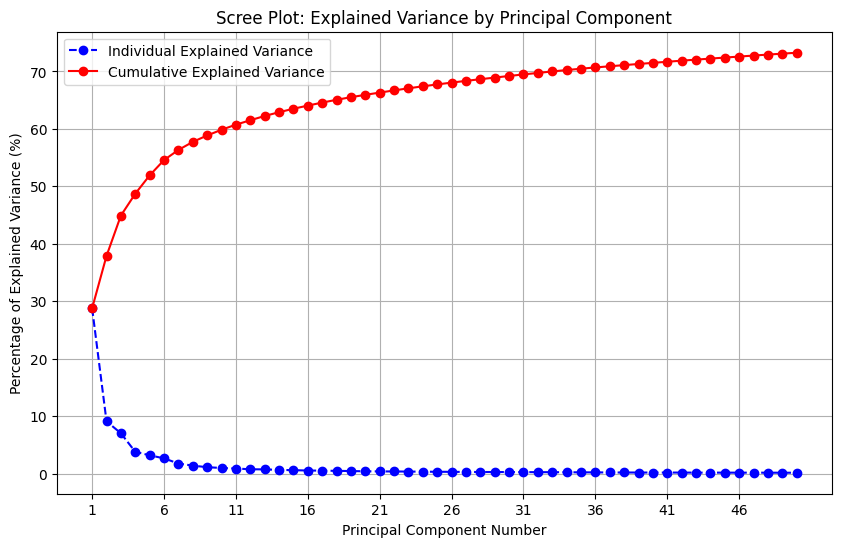

In [7]:
# --- 5. Dimensionality Reduction and Visualization ---
print("\n--- 5. Dimensionality Reduction and Visualization ---")

# --- PCA ---
print("\n--- Performing PCA ---")
pca = PCA(n_components=50)
principal_components = pca.fit_transform(filtered_scaled_expression_df)
pca_df = pd.DataFrame(data=principal_components,
                      columns=[f'PC{i+1}' for i in range(principal_components.shape[1])],
                      index=filtered_scaled_expression_df.index)

# Merge PCA results with clinical data for plotting
pca_df_merged = pca_df.merge(clinical_df, left_index=True, right_index=True, how='inner')

# Scree Plot (Explained Variance)
plt.figure(figsize=(10, 6))
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100,
         marker='o', linestyle='--', color='blue', label='Individual Explained Variance')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance * 100,
         marker='o', linestyle='-', color='red', label='Cumulative Explained Variance')
plt.title('Scree Plot: Explained Variance by Principal Component')
plt.xlabel('Principal Component Number')
plt.ylabel('Percentage of Explained Variance (%)')
plt.grid(True)
plt.legend()
plt.xticks(range(1, len(explained_variance_ratio) + 1, 5))
plt.show()


In [8]:
# PCA Score Plots (Interactive with Plotly)
# Define the columns to show on hover. This is a more robust approach.
hover_columns = [SAMPLE_TYPE_COL, BIOPSY_SITE_COL, 'Age', 'Gender', 'Biopsy subsite', 'Histological type', 'Sample_ID']

if len(pca_df_merged[SAMPLE_TYPE_COL].unique()) > 1:
    fig_pca_sample_type = px.scatter(pca_df_merged, x='PC1', y='PC2', color=SAMPLE_TYPE_COL,
                                     title=f'PCA of CRC RNA-seq Data (Colored by {SAMPLE_TYPE_COL})',
                                     labels={'PC1': f'PC1 ({explained_variance_ratio[0]*100:.2f}%)',
                                             'PC2': f'PC2 ({explained_variance_ratio[1]*100:.2f}%)'},
                                     hover_data=hover_columns)
    fig_pca_sample_type.show()
else:
    print(f"Skipping PCA plot by {SAMPLE_TYPE_COL}: Only one unique value found.")

if BIOPSY_SITE_COL in clinical_df.columns and len(pca_df_merged[BIOPSY_SITE_COL].unique()) > 1:
    fig_pca_biopsy_site = px.scatter(pca_df_merged, x='PC1', y='PC2', color=BIOPSY_SITE_COL,
                                     title=f'PCA of CRC RNA-seq Data (Colored by {BIOPSY_SITE_COL})',
                                     labels={'PC1': f'PC1 ({explained_variance_ratio[0]*100:.2f}%)',
                                             'PC2': f'PC2 ({explained_variance_ratio[1]*100:.2f}%)'},
                                     hover_data=hover_columns)
    fig_pca_biopsy_site.show()
else:
    print(f"Skipping PCA plot by {BIOPSY_SITE_COL}: Column not found or only one unique value.")


In [9]:
# --- UMAP ---
print("\n--- Performing UMAP ---")
# n_neighbors and min_dist are important UMAP parameters. Adjust as needed.
# init='random' can sometimes help with reproducibility if 'spectral' is unstable.
umap_2d = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
umap_projections = umap_2d.fit_transform(filtered_scaled_expression_df)
umap_df = pd.DataFrame(data=umap_projections,
                        columns=['UMAP1', 'UMAP2'],
                        index=filtered_scaled_expression_df.index)

umap_df_merged = umap_df.merge(clinical_df, left_index=True, right_index=True, how='inner')
umap_df_merged.index.name = 'Sample_ID' # Ensure the index has a name for hover_name

if len(umap_df_merged[SAMPLE_TYPE_COL].unique()) > 1:
    fig_umap_sample_type = px.scatter(umap_df_merged, x='UMAP1', y='UMAP2', color=SAMPLE_TYPE_COL,
                                        title=f'UMAP of CRC RNA-seq Data (Colored by {SAMPLE_TYPE_COL})',
                                        hover_data=hover_columns,
                                        hover_name=umap_df_merged.index.name) # Use the index name as the main hover text
    fig_umap_sample_type.show()
else:
    print(f"Skipping UMAP plot by {SAMPLE_TYPE_COL}: Only one unique value found.")

if BIOPSY_SITE_COL in clinical_df.columns and len(umap_df_merged[BIOPSY_SITE_COL].unique()) > 1:
    fig_umap_biopsy_site = px.scatter(umap_df_merged, x='UMAP1', y='UMAP2', color=BIOPSY_SITE_COL,
                                        title=f'UMAP of CRC RNA-seq Data (Colored by {BIOPSY_SITE_COL})',
                                        hover_data=hover_columns,
                                        hover_name=umap_df_merged.index.name) # Use the index name as the main hover text
    fig_umap_biopsy_site.show()
else:
    print(f"Skipping UMAP plot by {BIOPSY_SITE_COL}: Column not found or only one unique value.")




--- Performing UMAP ---



--- Performing PHATE ---
Calculating PHATE...
  Running PHATE on 2770 observations and 16752 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.55 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.40 seconds.
    Calculating affinities...
    Calculated affinities in 0.06 seconds.
  Calculated graph and diffusion operator in 5.07 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.21 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.73 seconds.
  Calculated landmark operator in 2.29 seconds.
  Calculating optimal t...
    Automatically selected t = 7
  Calculated optimal t in 0.93 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.32 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.24 seconds.
Calculated PHATE in 10.85 seconds.


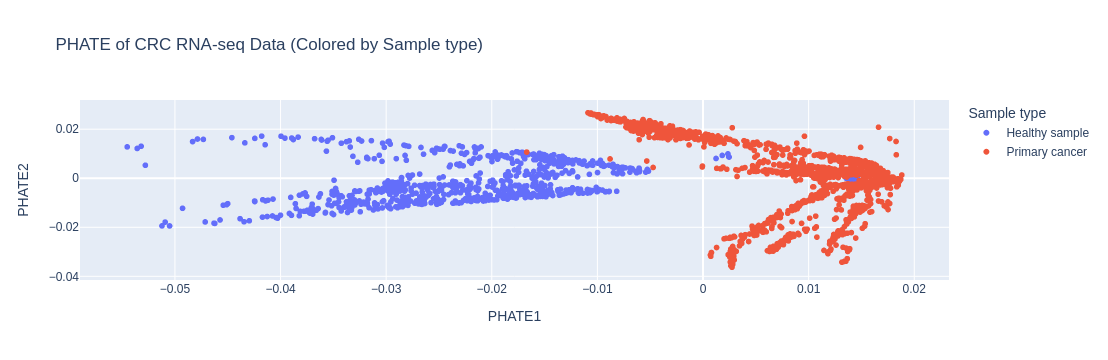

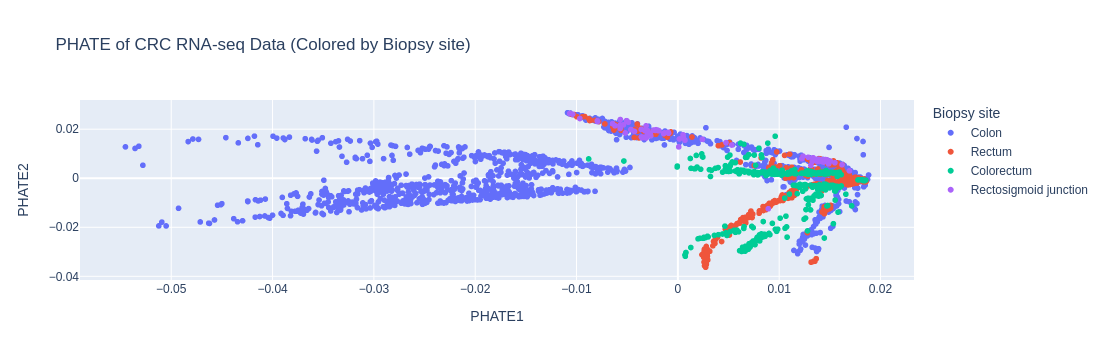

In [10]:
# --- PHATE ---
print("\n--- Performing PHATE ---")
# PHATE is good for preserving trajectories. Adjust 'knn' and 'decay' as needed.
phate_operator = phate.PHATE(n_components=2, random_state=42, knn=5, decay=15)
phate_projections = phate_operator.fit_transform(filtered_scaled_expression_df)
phate_df = pd.DataFrame(data=phate_projections,
                         columns=['PHATE1', 'PHATE2'],
                         index=filtered_scaled_expression_df.index)

phate_df_merged = phate_df.merge(clinical_df, left_index=True, right_index=True, how='inner')
phate_df_merged.index.name = 'Sample_ID' # Ensure the index has a name for hover_name

if len(phate_df_merged[SAMPLE_TYPE_COL].unique()) > 1:
    fig_phate_sample_type = px.scatter(phate_df_merged, x='PHATE1', y='PHATE2', color=SAMPLE_TYPE_COL,
                                         title=f'PHATE of CRC RNA-seq Data (Colored by {SAMPLE_TYPE_COL})',
                                         hover_data=hover_columns,
                                         hover_name=phate_df_merged.index.name) # Use the index name as the main hover text
    fig_phate_sample_type.show()
else:
    print(f"Skipping PHATE plot by {SAMPLE_TYPE_COL}: Only one unique value found.")

if BIOPSY_SITE_COL in clinical_df.columns and len(phate_df_merged[BIOPSY_SITE_COL].unique()) > 1:
    fig_phate_biopsy_site = px.scatter(phate_df_merged, x='PHATE1', y='PHATE2', color=BIOPSY_SITE_COL,
                                         title=f'PHATE of CRC RNA-seq Data (Colored by {BIOPSY_SITE_COL})',
                                         hover_data=hover_columns,
                                         hover_name=phate_df_merged.index.name) # Use the index name as the main hover text
    fig_phate_biopsy_site.show()
else:
    print(f"Skipping PHATE plot by {BIOPSY_SITE_COL}: Column not found or only one unique value.")



--- 6. Differential Expression Analysis (DGE) ---

--- Performing PyDESeq2 Analysis (Pre-Shrinkage) ---
####################################################################################################
## IMPORTANT: You have confirmed that your 'gexp.csv' contains **pycombat-seq adjusted integer** ##
####################################################################################################
Renamed column 'Sample type' to 'Sample_type' for PyDESeq2 analysis.
Pre-filtered gene counts for PyDESeq2. Initial genes: 22723, Remaining: 21994

Running PyDESeq2 analysis...
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.80 seconds.

Fitting dispersions...
... done in 5.84 seconds.

Fitting dispersion trend curve...
... done in 1.32 seconds.

Fitting MAP dispersions...
... done in 6.11 seconds.

Fitting LFCs...
... done in 13.75 seconds.

Calculating cook's distance...
... done in 5.33 seconds.

Replacing 3636 outlier genes.

Fitting dispersions...
... done in 1.18 seconds.

Fitting MAP dispersions...
... done in 1.11 seconds.

Fitting LFCs...
... done in 4.80 seconds.



PyDESeq2 analysis complete.

Retrieving non-shrunken LFC results...


Running Wald tests...
... done in 1.41 seconds.



Log2 fold change & Wald test p-value: Sample_type Primary cancer vs Healthy sample
              baseMean  log2FoldChange     lfcSE       stat         pvalue  \
A1BG         53.316501       -0.459025  0.087050  -5.273093   1.341435e-07   
A1BG-AS1     38.708100        0.424411  0.070365   6.031533   1.624111e-09   
A1CF        712.043893        0.716443  0.084487   8.479963   2.252658e-17   
A2M       10285.104690       -0.211358  0.039564  -5.342229   9.181075e-08   
A2M-AS1     155.958097       -0.009994  0.075497  -0.132375   8.946874e-01   
...                ...             ...       ...        ...            ...   
ZYG11A       38.308812        3.070192  0.106080  28.942122  3.525967e-184   
ZYG11B     1139.438390       -0.600201  0.037755 -15.897150   6.631381e-57   
ZYX        7505.884690        2.269756  0.044338  51.191948   0.000000e+00   
ZZEF1      3641.858956       -0.431158  0.045361  -9.505043   1.999653e-21   
ZZZ3       1216.746065        0.334261  0.033377  10.014622

Running Wald tests...
... done in 1.41 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: Sample_type Primary cancer vs Healthy sample
              baseMean  log2FoldChange     lfcSE       stat         pvalue  \
A1BG         53.316501       -0.459025  0.087050  -5.273093   1.341435e-07   
A1BG-AS1     38.708100        0.424411  0.070365   6.031533   1.624111e-09   
A1CF        712.043893        0.716443  0.084487   8.479963   2.252658e-17   
A2M       10285.104690       -0.211358  0.039564  -5.342229   9.181075e-08   
A2M-AS1     155.958097       -0.009994  0.075497  -0.132375   8.946874e-01   
...                ...             ...       ...        ...            ...   
ZYG11A       38.308812        3.070192  0.106080  28.942122  3.525967e-184   
ZYG11B     1139.438390       -0.600201  0.037755 -15.897150   6.631381e-57   
ZYX        7505.884690        2.269756  0.044338  51.191948   0.000000e+00   
ZZEF1      3641.858956       -0.431158  0.045361  -9.505043   1.999653e-21   
ZZZ3       1216.746065        0.334261  0.033377  10.014622

... done in 4.58 seconds.



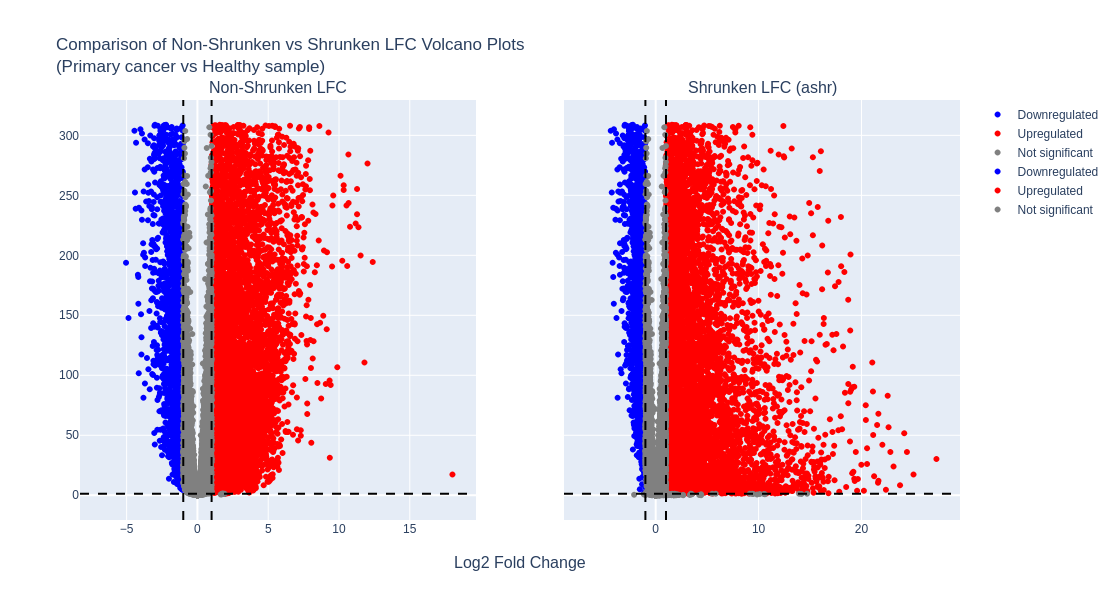

In [11]:
# --- 6. Differential Expression Analysis (DGE) ---
print("\n--- 6. Differential Expression Analysis (DGE) ---")

# Ensure there are at least two distinct sample types for DGE
if len(clinical_df[SAMPLE_TYPE_COL].unique()) < 2:
    print(f"Cannot perform differential expression analysis: Less than two unique '{SAMPLE_TYPE_COL}' types found.")
else:
    # --- Option 1: PyDESeq2 Analysis (for both non-shrunken and shrunken LFC) ---
    print("\n--- Performing PyDESeq2 Analysis (Pre-Shrinkage) ---")
    print("####################################################################################################")
    print("## IMPORTANT: You have confirmed that your 'gexp.csv' contains **pycombat-seq adjusted integer** ##")
    ## counts. The authors of ComBat-seq state that their adjusted counts are compatible as input   ##
    ## for downstream differential expression software like DESeq2, as they preserve integer values  ##
    ## and a count-like distribution.                                                               ##
    ## Therefore, using 'gene_expression_df' directly (after converting to int) as input for        ##
    ## PyDESeq2 is appropriate in this specific scenario.                                           ##
    ## However, in a general context, DESeq2 is ideally run on *original, uncorrected raw integer* ##
    ## counts to leverage its full statistical model for normalization and dispersion estimation.    ##
    print("####################################################################################################")

    try:
        from pydeseq2.ds import DeseqStats
        import plotly.graph_objects as go
        from plotly.subplots import make_subplots
        
        deseq_clinical_df = clinical_df.copy()
        
        if 'Sample type' in deseq_clinical_df.columns:
            deseq_clinical_df.rename(columns={'Sample type': 'Sample_type'}, inplace=True)
            SAMPLE_TYPE_COL_FIXED = 'Sample_type'
            print(f"Renamed column 'Sample type' to '{SAMPLE_TYPE_COL_FIXED}' for PyDESeq2 analysis.")
        else:
            SAMPLE_TYPE_COL_FIXED = SAMPLE_TYPE_COL
        
        if 'Biopsy subsite' in deseq_clinical_df.columns:
             deseq_clinical_df.rename(columns={'Biopsy subsite': 'Biopsy_subsite'}, inplace=True)
        if 'Biopsy site' in deseq_clinical_df.columns:
             deseq_clinical_df.rename(columns={'Biopsy site': 'Biopsy_site'}, inplace=True)

        min_samples_with_count = 5
        min_count = 10

        counts_for_deseq2 = gene_expression_df.fillna(0).astype(int)
        
        filtered_genes = (counts_for_deseq2 >= min_count).sum(axis=0) >= min_samples_with_count
        counts_for_deseq2 = counts_for_deseq2.loc[:, filtered_genes]

        print(f"Pre-filtered gene counts for PyDESeq2. Initial genes: {gene_expression_df.shape[1]}, Remaining: {counts_for_deseq2.shape[1]}")

        deseq_clinical_df[SAMPLE_TYPE_COL_FIXED] = deseq_clinical_df[SAMPLE_TYPE_COL_FIXED].astype('category')

        dds = DeseqDataSet(
            counts=counts_for_deseq2,
            metadata=deseq_clinical_df,
            design_factors=[SAMPLE_TYPE_COL_FIXED],
            refit_cooks=True,
            inference=DefaultInference()
        )

        print("\nRunning PyDESeq2 analysis...")
        dds.deseq2()
        print("PyDESeq2 analysis complete.")

        if HEALTHY_SAMPLE_TYPE in deseq_clinical_df[SAMPLE_TYPE_COL_FIXED].unique() and \
           CANCER_SAMPLE_TYPE in deseq_clinical_df[SAMPLE_TYPE_COL_FIXED].unique():
            
            # --- Get the NON-SHRUNKEN results first. ---
            print("\nRetrieving non-shrunken LFC results...")
            stat_res_unshrunken = DeseqStats(
                dds=dds,
                contrast=[SAMPLE_TYPE_COL_FIXED, CANCER_SAMPLE_TYPE, HEALTHY_SAMPLE_TYPE],
                inference=DefaultInference()
            )
            stat_res_unshrunken.summary()
            res_pydeseq2_unshrunken = stat_res_unshrunken.results_df
            
            print(f"\nNon-Shrunken LFC Results (Top 10):")
            print(res_pydeseq2_unshrunken.sort_values('padj').head(10))

            # --- Get the SHRUNKEN results. ---
            print("\nRetrieving shrunken LFC results...")
            stat_res_shrunken = DeseqStats(
                dds=dds,
                contrast=[SAMPLE_TYPE_COL_FIXED, CANCER_SAMPLE_TYPE, HEALTHY_SAMPLE_TYPE],
                inference=DefaultInference()
            )
            stat_res_shrunken.summary()
            correct_coeff_name = f"{SAMPLE_TYPE_COL_FIXED}[T.{CANCER_SAMPLE_TYPE}]"
            stat_res_shrunken.lfc_shrink(coeff=correct_coeff_name)
            res_pydeseq2_shrunken = stat_res_shrunken.results_df
            
            print(f"\nShrunken LFC Results (Top 10):")
            print(res_pydeseq2_shrunken.sort_values('padj').head(10))

            # --- Generate the Side-by-Side Volcano Plots ---
            print("\nGenerating interactive side-by-side volcano plots...")
            
            padj_threshold = 0.05
            lfc_threshold = 1.0

            # Categorize genes for both dataframes
            def categorize_genes(df):
                df['Expression'] = 'Not significant'
                df.loc[(df['padj'] < padj_threshold) & (df['log2FoldChange'] > lfc_threshold), 'Expression'] = 'Upregulated'
                df.loc[(df['padj'] < padj_threshold) & (df['log2FoldChange'] < -lfc_threshold), 'Expression'] = 'Downregulated'
                df['-log10(padj)'] = -np.log10(df['padj'])
                return df

            res_pydeseq2_unshrunken = categorize_genes(res_pydeseq2_unshrunken)
            res_pydeseq2_shrunken = categorize_genes(res_pydeseq2_shrunken)
            
            # Use make_subplots to create a figure with two subplots
            fig = make_subplots(rows=1, cols=2,
                                subplot_titles=[f'Non-Shrunken LFC', f'Shrunken LFC (ashr)'],
                                x_title='Log2 Fold Change',
                                shared_yaxes=True,
                                horizontal_spacing=0.1)

            # Define marker colors and hover data
            color_map = {'Upregulated': 'red', 'Downregulated': 'blue', 'Not significant': 'grey'}
            hover_data = {'log2FoldChange': ':.3f', 'pvalue': ':.2e', 'padj': ':.2e', '-log10(padj)': False}

            # Add non-shrunken plot to the left subplot
            for expression_cat in ['Downregulated', 'Upregulated', 'Not significant']:
                df_subset = res_pydeseq2_unshrunken[res_pydeseq2_unshrunken['Expression'] == expression_cat]
                fig.add_trace(
                    go.Scatter(
                        x=df_subset['log2FoldChange'],
                        y=df_subset['-log10(padj)'],
                        mode='markers',
                        marker=dict(color=color_map[expression_cat]),
                        name=expression_cat,
                        text=df_subset.index,
                        hoverinfo='text',
                        customdata=df_subset[['log2FoldChange', 'pvalue', 'padj']],
                        hovertemplate="Gene: %{text}<br>Log2FC: %{customdata[0]:.3f}<br>p-value: %{customdata[1]:.2e}<br>padj: %{customdata[2]:.2e}<extra></extra>"
                    ),
                    row=1, col=1
                )

            # Add shrunken plot to the right subplot
            for expression_cat in ['Downregulated', 'Upregulated', 'Not significant']:
                df_subset = res_pydeseq2_shrunken[res_pydeseq2_shrunken['Expression'] == expression_cat]
                fig.add_trace(
                    go.Scatter(
                        x=df_subset['log2FoldChange'],
                        y=df_subset['-log10(padj)'],
                        mode='markers',
                        marker=dict(color=color_map[expression_cat]),
                        name=expression_cat,
                        text=df_subset.index,
                        hoverinfo='text',
                        customdata=df_subset[['log2FoldChange', 'pvalue', 'padj']],
                        hovertemplate="Gene: %{text}<br>Log2FC: %{customdata[0]:.3f}<br>p-value: %{customdata[1]:.2e}<br>padj: %{customdata[2]:.2e}<extra></extra>"
                    ),
                    row=1, col=2
                )
            
            # Add threshold lines to both subplots
            fig.add_hline(y=-np.log10(padj_threshold), line_dash="dash", line_color="black", row='all', col='all')
            fig.add_vline(x=lfc_threshold, line_dash="dash", line_color="black", row='all', col='all')
            fig.add_vline(x=-lfc_threshold, line_dash="dash", line_color="black", row='all', col='all')

            fig.update_layout(title_text=f'Comparison of Non-Shrunken vs Shrunken LFC Volcano Plots<br>({CANCER_SAMPLE_TYPE} vs {HEALTHY_SAMPLE_TYPE})', height=600, width=1200)
            fig.show()

        else:
            print(f"Cannot perform PyDESeq2 comparison: '{HEALTHY_SAMPLE_TYPE}' or '{CANCER_SAMPLE_TYPE}' not found in '{SAMPLE_TYPE_COL_FIXED}'.")

    except ImportError:
        print("PyDESeq2 not installed. Please install it: pip install pydeseq2")
    except Exception as e:
        print(f"An error occurred during PyDESeq2 analysis: {e}")
        print("Please ensure your input data for PyDESeq2 are integer counts and PyDESeq2 is correctly installed.")


--- 7. Gene Set Enrichment Analysis (GSEA) Integration ---
Prepared 21994 genes for GSEA.
Top 5 genes by LFC for GSEA:
MIR30D      27.283222
MIR101-2    25.053912
MIR103A1    24.416246
MIR30B      24.153062
MIR30A      23.744554
Name: log2FoldChange, dtype: float64

Running GSEA with gene sets: KEGG_2021_Human...

GSEA completed. Summary of enriched pathways (Top 10):
      Name                                               Term        ES  \
0  prerank                   KEGG_2021_Human__Renin secretion -0.450519   
1  prerank                 KEGG_2021_Human__Adherens junction -0.336755   
2  prerank                  KEGG_2021_Human__Circadian rhythm -0.522706   
3  prerank               KEGG_2021_Human__MicroRNAs in cancer  0.826068   
4  prerank  KEGG_2021_Human__Regulation of lipolysis in ad... -0.339448   
5  prerank  KEGG_2021_Human__SNARE interactions in vesicul... -0.404899   
6  prerank            KEGG_2021_Human__Olfactory transduction  0.736543   
7  prerank         KEGG_2021

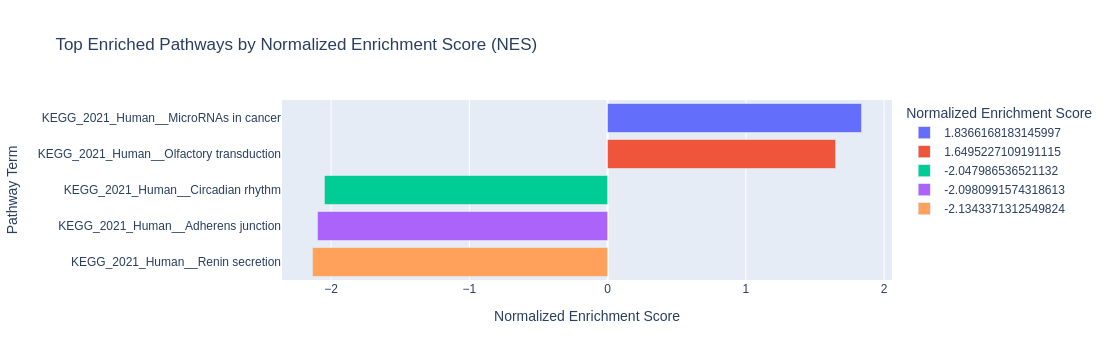

In [13]:
# --- 7. Gene Set Enrichment Analysis (GSEA) Integration ---
print("\n--- 7. Gene Set Enrichment Analysis (GSEA) Integration ---")

# --- FIX: Use shrunken LFC results for gene ranking ---
if 'res_pydeseq2_shrunken' in locals():
    # GSEApy's prerank function takes a Pandas Series with gene names as index and scores as values.
    # We use the shrunken log2FoldChange for more stable ranking.
    gsea_gene_scores = res_pydeseq2_shrunken['log2FoldChange'].dropna().sort_values(ascending=False)
else:
    gsea_gene_scores = pd.Series()
    print("Shrunken PyDESeq2 results not found. Skipping GSEA.")

if gsea_gene_scores.empty:
    print("No gene scores available for GSEA. Skipping GSEA.")
else:
    print(f"Prepared {len(gsea_gene_scores)} genes for GSEA.")
    print("Top 5 genes by LFC for GSEA:")
    print(gsea_gene_scores.head())

    gene_set_libraries = ['KEGG_2021_Human']

    try:
        import gseapy as gp
        # Run pre-ranked GSEA
        print(f"\nRunning GSEA with gene sets: {', '.join(gene_set_libraries)}...")
        prerank_results = gp.prerank(
            rnk=gsea_gene_scores,
            gene_sets=gene_set_libraries,
            outdir='gseapy_prerank_results',
            seed=42,
            min_size=5,
            max_size=500,
            permutation_num=1000,
            no_plot=False,
            processes=1
        )

        print("\nGSEA completed. Summary of enriched pathways (Top 10):")
        print(prerank_results.res2d.head(10))

        # --- New: Visualize top enriched pathways using Plotly. ---
        if not prerank_results.res2d.empty:
            significant_pathways = prerank_results.res2d[prerank_results.res2d['FDR q-val'] < 0.25]
            if not significant_pathways.empty:
                print(f"\nFound {len(significant_pathways)} significant pathways (FDR q-val < 0.25).")
                top_pathways_plot = significant_pathways.sort_values('NES', ascending=False).head(20)
                
                fig_pathways = px.bar(
                    top_pathways_plot,
                    x='NES',
                    y='Term',
                    orientation='h',
                    color='NES',
                    color_continuous_scale=px.colors.diverging.RdBu,
                    title='Top Enriched Pathways by Normalized Enrichment Score (NES)',
                    labels={'NES': 'Normalized Enrichment Score', 'Term': 'Pathway Term'},
                    hover_data={'NES': ':.3f', 'FDR q-val': ':.2e'}
                )
                fig_pathways.update_layout(yaxis={'categoryorder':'total ascending'})
                fig_pathways.show()
            else:
                print("No significant pathways found (FDR q-val < 0.25).")
        else:
            print("No GSEA results to display.")

    except ImportError:
        print("GSEApy not installed. Please install it: pip install gseapy")
    except Exception as e:
        print(f"An error occurred during GSEApy analysis: {e}")
        print("Ensure you have an active internet connection for Enrichr gene set downloads.")
        


--- 7. Gene Set Enrichment Analysis (GSEA) Integration ---
Prepared 21994 genes for GSEA.
Top 5 genes by LFC for GSEA:
MIR30D      27.283222
MIR101-2    25.053912
MIR103A1    24.416246
MIR30B      24.153062
MIR30A      23.744554
Name: log2FoldChange, dtype: float64

Running GSEA with gene sets: KEGG_2021_Human, GO_Biological_Process_2021...

GSEA completed. Summary of enriched pathways (Top 10):
      Name                                               Term        ES  \
0  prerank  GO_Biological_Process_2021__regulation of rele... -0.771483   
1  prerank  GO_Biological_Process_2021__regulation of card... -0.516568   
2  prerank  GO_Biological_Process_2021__positive regulatio... -0.602864   
3  prerank  GO_Biological_Process_2021__regulation of card... -0.759007   
4  prerank  GO_Biological_Process_2021__semaphorin-plexin ... -0.524108   
5  prerank  GO_Biological_Process_2021__retrograde axonal ... -0.766766   
6  prerank  GO_Biological_Process_2021__presynaptic endocy... -0.620235   


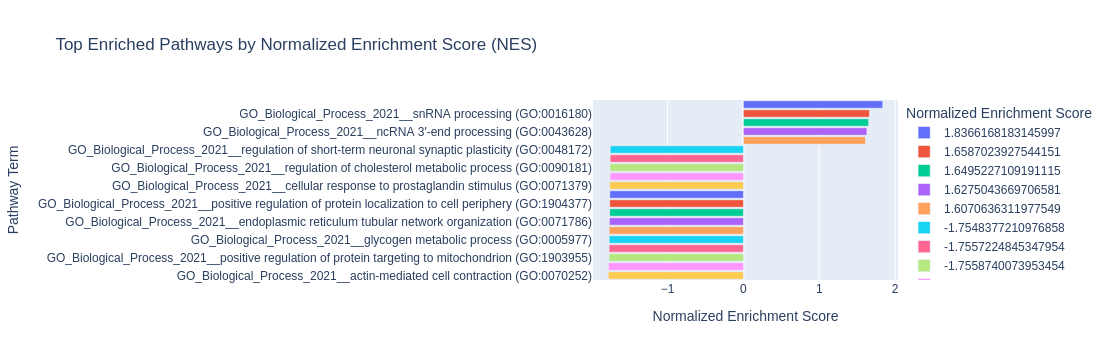


--- Analysis Complete ---
Review the plots to understand the data structure and potential biological clusters.
Interpret DGE results, keeping in mind the input data type for PyDESeq2.
GSEA results provide functional insights into the observed gene expression changes.


In [ ]:
# --- 7. Gene Set Enrichment Analysis (GSEA) Integration ---
print("\n--- 7. Gene Set Enrichment Analysis (GSEA) Integration ---")

# --- FIX: Use shrunken LFC results for gene ranking ---
if 'res_pydeseq2_shrunken' in locals():
    # GSEApy's prerank function takes a Pandas Series with gene names as index and scores as values.
    # We use the shrunken log2FoldChange for more stable ranking.
    gsea_gene_scores = res_pydeseq2_shrunken['log2FoldChange'].dropna().sort_values(ascending=False)
else:
    gsea_gene_scores = pd.Series()
    print("Shrunken PyDESeq2 results not found. Skipping GSEA.")

if gsea_gene_scores.empty:
    print("No gene scores available for GSEA. Skipping GSEA.")
else:
    print(f"Prepared {len(gsea_gene_scores)} genes for GSEA.")
    print("Top 5 genes by LFC for GSEA:")
    print(gsea_gene_scores.head())

    gene_set_libraries = [ 'GO_Biological_Process_2021']

    try:
        import gseapy as gp
        # Run pre-ranked GSEA
        print(f"\nRunning GSEA with gene sets: {', '.join(gene_set_libraries)}...")
        prerank_results = gp.prerank(
            rnk=gsea_gene_scores,
            gene_sets=gene_set_libraries,
            outdir='gseapy_prerank_results',
            seed=42,
            min_size=5,
            max_size=500,
            permutation_num=1000,
            no_plot=False,
            processes=1
        )

        print("\nGSEA completed. Summary of enriched pathways (Top 10):")
        print(prerank_results.res2d.head(10))

        # --- New: Visualize top enriched pathways using Plotly. ---
        if not prerank_results.res2d.empty:
            significant_pathways = prerank_results.res2d[prerank_results.res2d['FDR q-val'] < 0.25]
            if not significant_pathways.empty:
                print(f"\nFound {len(significant_pathways)} significant pathways (FDR q-val < 0.25).")
                top_pathways_plot = significant_pathways.sort_values('NES', ascending=False).head(20)
                
                fig_pathways = px.bar(
                    top_pathways_plot,
                    x='NES',
                    y='Term',
                    orientation='h',
                    color='NES',
                    color_continuous_scale=px.colors.diverging.RdBu,
                    title='Top Enriched Pathways by Normalized Enrichment Score (NES)',
                    labels={'NES': 'Normalized Enrichment Score', 'Term': 'Pathway Term'},
                    hover_data={'NES': ':.3f', 'FDR q-val': ':.2e'}
                )
                fig_pathways.update_layout(yaxis={'categoryorder':'total ascending'})
                fig_pathways.show()
            else:
                print("No significant pathways found (FDR q-val < 0.25).")
        else:
            print("No GSEA results to display.")

    except ImportError:
        print("GSEApy not installed. Please install it: pip install gseapy")
    except Exception as e:
        print(f"An error occurred during GSEApy analysis: {e}")
        print("Ensure you have an active internet connection for Enrichr gene set downloads.")

print("\n--- Analysis Complete ---")
print("Review the plots to understand the data structure and potential biological clusters.")
print("Interpret DGE results, keeping in mind the input data type for PyDESeq2.")
print("GSEA results provide functional insights into the observed gene expression changes.")